In [231]:
#pairs trading

In [232]:
import yfinance as yf
import pandas as pd

from itertools import combinations

import numpy as np

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import matplotlib.pyplot as plt
from pytickersymbols import PyTickerSymbols
import os



import warnings
warnings.filterwarnings("ignore")


# S&P500 screener

In this project we will
1. Fetch from yfinance all the companies of the s&p
2. calculate the cointegration between pairs
3. establish a trading strategy utilizing the spread and the zscore
4. Analyze the results and conclude on the limitation of our approach
5. We will then try an alternative model that uses rolling windows which would do better on real life scenario
> Ajouter une citation



In [260]:

use_csv = True #change to false if you want new data each run
filename = "SP500_prices.csv"

if use_csv and os.path.exists(filename):
    print(f"{filename} already exists --> using file")
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
else:
    print(f"{filename} does not exist --> downloading from Yahoo Finance")

    # fetching tickers list S&P 500
    stock_data = PyTickerSymbols()
    SP500 = stock_data.get_stocks_by_index('S&P 500')
    TICKERS = [TICK['symbol'] for TICK in SP500]

    # Downloading closing datas
    df = yf.download(TICKERS, start="2023-01-01", end="2023-09-30")['Close']

    # Download to csv to reuse
    df.to_csv(filename, index=True)
    print(f"Saved to {filename}")

print(df.head())


SP500_prices.csv already exists --> using file
                     A    AAL         AAP        AAPL        ABBV  ABC  ABMD  \
Date                                                                           
2023-01-03  147.012177  12.74  143.220459  123.330635  146.532608  NaN   NaN   
2023-01-04  148.609299  13.59  143.551270  124.602699  147.714798  NaN   NaN   
2023-01-05  149.040421  13.99  144.751541  123.281334  147.534271  NaN   NaN   
2023-01-06  144.690018  14.18  145.564331  127.817345  150.295654  NaN   NaN   
2023-01-09  144.494049  14.61  143.900940  128.339996  145.882889  NaN   NaN   

                   ABT       ACGL         ACN  ...       WYNN        XEL  \
Date                                           ...                         
2023-01-03  103.829872  59.393120  258.138916  ...  83.384628  63.671185   
2023-01-04  105.374336  59.687901  257.260132  ...  88.537109  64.216393   
2023-01-05  104.985863  59.849552  251.185394  ...  88.965668  62.916988   
2023-01-06  

We now need to check every combination with

(number of stocks)! /2!(number of stocks-2)!

here we have 498 Tickers so

* => 498!/2!(496)!
* => 498 * 497 * 496!/2!(496)!
* => (498*497)/2

In [243]:
498*497/2

123753.0

In this notebook, we restrict the analysis to stock pairs with sufficiently high correlation in order to reduce computational cost. Later, I will provide a complementary implementation (in Objective-C) that evaluates all possible combinations across the S&P 500 universe, allowing us to check whether correlation filtering was overly restrictive.

In [244]:


df_combination = pd.DataFrame(combinations(df.columns,2))
df_combination.columns = ['Stock1', 'Stock2']
df_combination

,Stock1,Stock2
0,A,AAL
1,A,AAP
2,A,AAPL
3,A,ABBV
4,A,ABC
...,...,...
123748,ZBH,ZION
123749,ZBH,ZTS
123750,ZBRA,ZION
123751,ZBRA,ZTS


let's filter by correlation

In [245]:
df_combination = pd.DataFrame(combinations(df.columns, 2), columns=['Stock1','Stock2'])
def pair_corr(row):
    s1 = df[row['Stock1']]
    s2 = df[row['Stock2']]
    return np.corrcoef(s1, s2)[0,1]

df_combination['correlation'] = df_combination.apply(pair_corr, axis=1)

df_combination.head()

,Stock1,Stock2,correlation
0,A,AAL,0.129968
1,A,AAP,0.921043
2,A,AAPL,-0.839707
3,A,ABBV,0.352612
4,A,ABC,NaN


Filtering for very high correlation

In [246]:
df_combination = df_combination[df_combination.correlation > 0.95]
df_combination

,Stock1,Stock2,correlation
233,A,INCY,0.962241
471,A,WAT,0.952759
1595,AAPL,CPRT,0.959298
1598,AAPL,CRM,0.957978
1799,AAPL,MSFT,0.971048
...,...,...,...
117390,RCL,VMC,0.966226
117827,RF,USB,0.978226
119248,SCHW,USB,0.954697
119286,SCHW,ZION,0.961418


In [247]:

def do_reg(stock1, stock2):
  """
  The function do_reg(stock1, stock2) performs a simple linear regression between two stock price series and then tests whether the residuals are stationary:
  """
  X = df[stock1].values
  y = df[stock2].values

  X = sm.add_constant(X)
  model = sm.OLS(y, X).fit()
  alpha,beta = model.params

  residuals = y - (alpha + beta * X[:,1])

  if np.isnan(residuals).any():
    return np.nan
  adf_results = adfuller(residuals)

  return adf_results[0], adf_results[1], beta, alpha



In [321]:
df_combination[['adf_stat', 'p_value', 'beta', 'alpha']] = df_combination.apply(lambda row:pd.Series(do_reg(row['Stock1'], row['Stock2'])), axis=1)
df_combination[df_combination.p_value < 0.005].sort_values(by='adf_stat') #adjust the coint to your liking

,Stock1,Stock2,correlation,adf_stat,p_value,beta,alpha
111166,NWL,WAT,0.951572,-5.834704,3.901029e-07,12.390244,165.171700
67267,EQIX,MCO,0.959278,-5.679512,8.550436e-07,0.514185,-46.849895
14060,AMCR,CCI,0.967084,-5.529028,1.805104e-06,18.409680,-68.400669
110307,NTAP,STZ,0.951966,-5.001578,2.203408e-05,2.703861,49.530103
41437,CHD,RSG,0.968993,-4.982314,2.405306e-05,1.567247,-2.898909
...,...,...,...,...,...,...,...
79460,GL,USB,0.952482,-3.663060,4.663794e-03,0.978677,-74.126187
104529,MLM,RCL,0.967955,-3.661243,4.692533e-03,0.365386,-62.209089
32787,BRK-B,WMT,0.954392,-3.657894,4.745934e-03,0.122527,8.547296
44214,CMA,PFG,0.951742,-3.656621,4.766393e-03,0.572545,46.203621


Let's quickly take the exemple of the most cointegrated pair

In [250]:
spread = df['WAT'] - (165.171696 + 12.390244 * df['NWL'])

In [251]:
#computing zscore
spread_mean = spread.mean()
spread_std = spread.std()
z_score = (spread - spread_mean) / spread_std

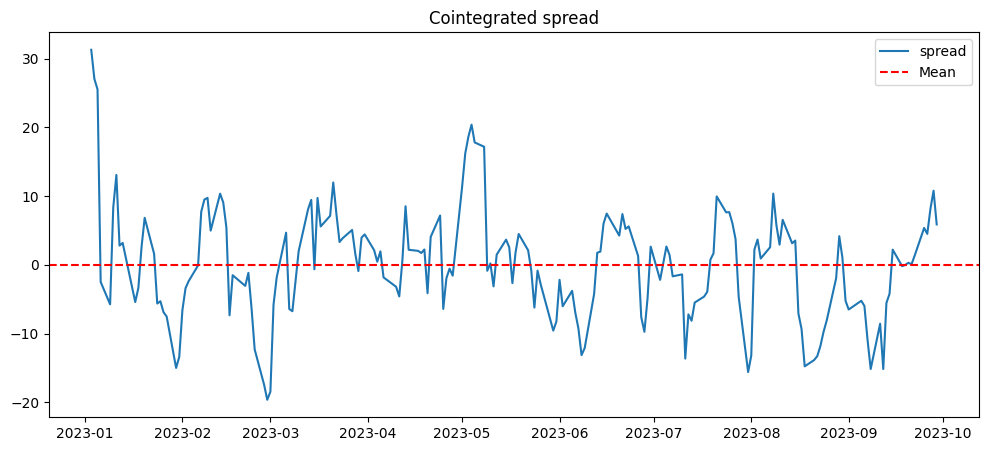

In [252]:
plt.figure(figsize=(12,5))
plt.plot(spread, label='spread')
plt.axhline(spread.mean(), color='red', linestyle='--', label="Mean")
plt.legend()
plt.title('Cointegrated spread')
plt.show()

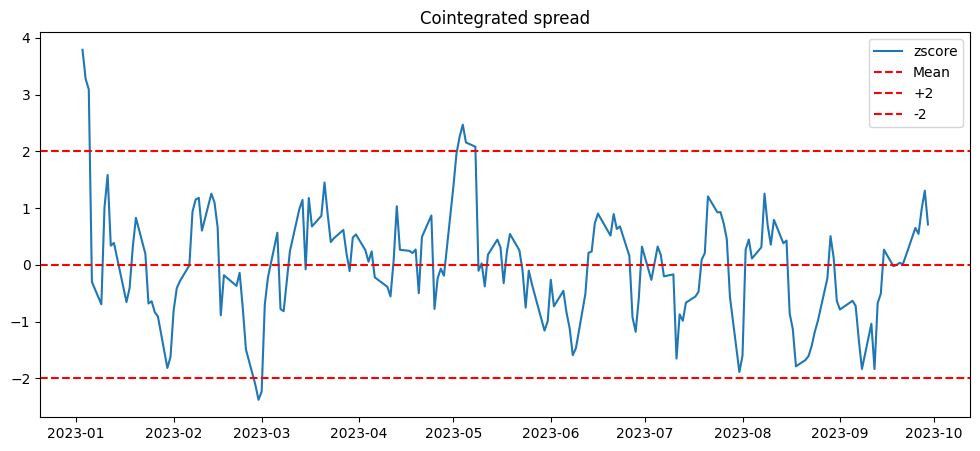

In [253]:
plt.figure(figsize=(12,5))
plt.plot(z_score, label='zscore')
plt.axhline(spread.mean(), color='red', linestyle='--', label="Mean")

plt.axhline(2, color='red', linestyle='--', label="+2")
plt.axhline(-2, color='red', linestyle='--', label="-2")

plt.legend()
plt.title('Cointegrated spread')
plt.show()

In [313]:
cointegrated_pairs = df_combination[df_combination.p_value < 0.06].sort_values(by='adf_stat')
print(f"Found {len(cointegrated_pairs)} cointegrated pairs")
best_pair = cointegrated_pairs.iloc[5]
stock1, stock2 = best_pair['Stock1'], best_pair['Stock2']
alpha, beta = best_pair['alpha'], best_pair['beta']

print(f"Selected pair: {stock1} vs {stock2}")
print(f"Alpha: {alpha:.4f}, Beta: {beta:.4f}")

# Calculate spread and z-score
spread = df[stock2] - (alpha + beta * df[stock1])
spread_mean = spread.mean()
spread_std = spread.std()
z_score = (spread - spread_mean) / spread_std

Found 137 cointegrated pairs
Selected pair: GE vs LIN
Alpha: 191.0872, Beta: 2.0234


In [283]:
# First, let's examine the z-score behavior and why no trades occurred
print("DEBUGGING ANALYSIS:")
print("="*50)

# Check z-score statistics
print(f"Z-score range: [{z_score.min():.2f}, {z_score.max():.2f}]")
print(f"Z-score mean: {z_score.mean():.2f}")
print(f"Z-score std: {z_score.std():.2f}")

# Check how often z-score exceeds thresholds
above_upper = (z_score > 2).sum()
below_lower = (z_score < -2).sum()
total_periods = len(z_score)
print(f"Z-score > 2: {above_upper} times ({above_upper/total_periods*100:.1f}%)")
print(f"Z-score < -2: {below_lower} times ({below_lower/total_periods*100:.1f}%)")

# Now let's check the rolling cointegration issue more carefully
rolling_window = 60
rolling_pvalues = []
cointegrated_count = 0

for i in range(rolling_window, len(df)):
    sub = df.iloc[i-rolling_window:i]
    _, pval, _ = coint(sub[stock1], sub[stock2])
    rolling_pvalues.append(pval)
    if pval < 0.01:
        cointegrated_count += 1

print(f"\nRolling Cointegration Analysis:")
print(f"Total rolling periods: {len(rolling_pvalues)}")
print(f"Cointegrated periods (p < 0.01): {cointegrated_count} ({cointegrated_count/len(rolling_pvalues)*100:.1f}%)")
print(f"Average rolling p-value: {np.mean(rolling_pvalues):.4f}")
print(f"Median rolling p-value: {np.median(rolling_pvalues):.4f}")

# Let's also check if there are ANY periods where both conditions are met
potential_trades = 0
for i in range(rolling_window, len(df)):
    current_z = z_score.iloc[i]
    if abs(current_z) > 2 and rolling_pvalues[i-rolling_window] < 0.01:
        potential_trades += 1

print(f"Potential trade opportunities: {potential_trades}")

DEBUGGING ANALYSIS:
Z-score range: [-2.32, 3.30]
Z-score mean: -0.00
Z-score std: 1.00
Z-score > 2: 4 times (2.1%)
Z-score < -2: 3 times (1.6%)

Rolling Cointegration Analysis:
Total rolling periods: 127
Cointegrated periods (p < 0.01): 6 (4.7%)
Average rolling p-value: 0.3893
Median rolling p-value: 0.3292
Potential trade opportunities: 0


RUNNING PRACTICAL PAIRS TRADING BACKTEST

Trading GE/LIN from 2023-01-03 to 2023-09-29
Z-score opportunities: 4 above, 3 below
📈 ENTER LONG: 2023-02-17, z=-2.04
🔄 EXIT LONG_SPREAD: 2023-02-24, z=1.78, PnL=$+327.20 (+3.27%), Reason: Mean reversion
📉 ENTER SHORT: 2023-03-03, z=3.30
🔄 EXIT SHORT_SPREAD: 2023-03-09, z=-0.50, PnL=$+73.84 (+0.71%), Reason: Mean reversion
📈 ENTER LONG: 2023-03-15, z=-2.12
🔄 EXIT LONG_SPREAD: 2023-03-31, z=0.14, PnL=$+551.69 (+5.30%), Reason: Mean reversion

PRACTICAL BACKTEST RESULTS
Trading Pair: GE / LIN
Period: 2023-01-03 to 2023-09-29
Initial Capital: $10,000.00
Final Capital: $10,952.73
Total Return: 9.53%
Total PnL: $+952.73
Sharpe Ratio: 1.72
Max Drawdown: 0.00%
Total Trades: 3
Win Rate: 100.0%
Average Trade Return: 3.10%
Dates length: 188, Portfolio values length: 188


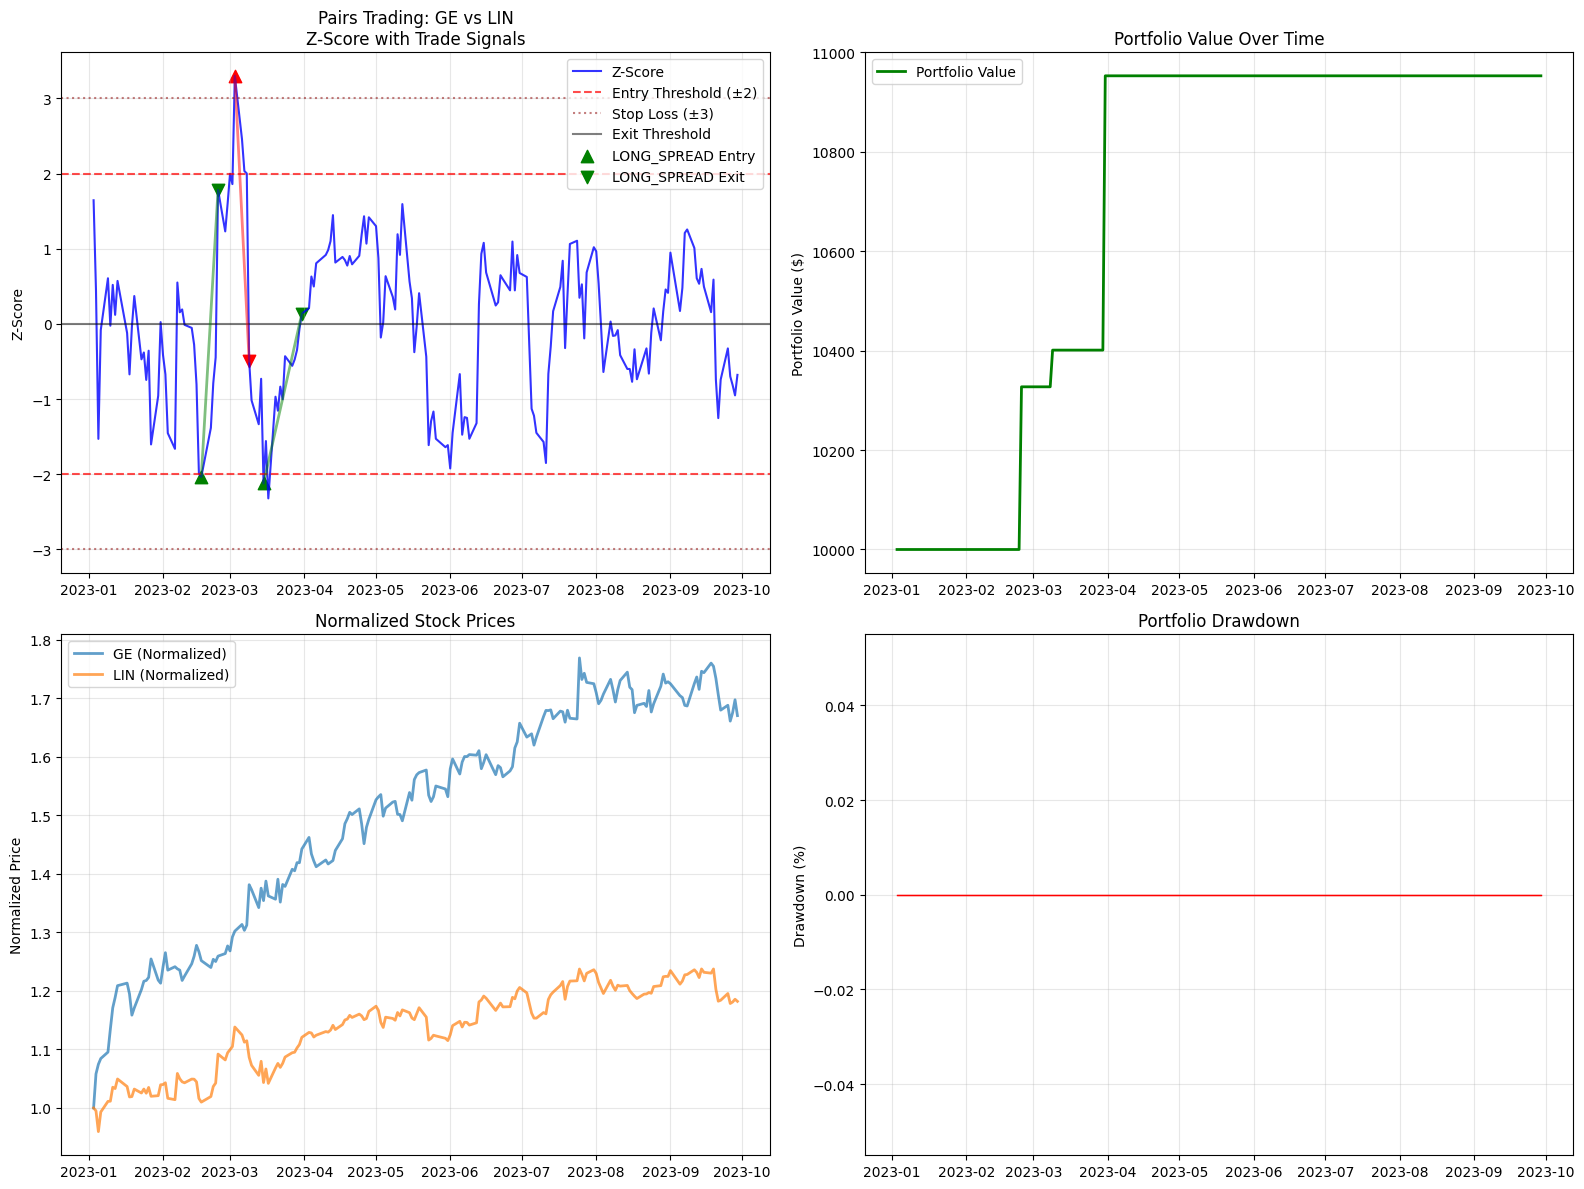


DETAILED TRADE ANALYSIS:
🟢 Trade 1: LONG_SPREAD  | Entry: 2023-02-17 (z=-2.04) | Exit: 2023-02-24 (z= 1.78) | Held:  7 days | PnL: $ 327.20 (  3.27%) | Reason: Mean reversion
🟢 Trade 2: SHORT_SPREAD | Entry: 2023-03-03 (z= 3.30) | Exit: 2023-03-09 (z=-0.50) | Held:  6 days | PnL: $  73.84 (  0.71%) | Reason: Mean reversion
🟢 Trade 3: LONG_SPREAD  | Entry: 2023-03-15 (z=-2.12) | Exit: 2023-03-31 (z= 0.14) | Held: 16 days | PnL: $ 551.69 (  5.30%) | Reason: Mean reversion

STRATEGY ANALYSIS:
• Z-score exceeded ±2.0 on 7 days
• Maximum z-score: 3.30, Minimum z-score: -2.32
• Z-score volatility (std): 1.00
• Average holding period: 9.7 days
• Average z-score reversion per trade: 3.29


In [284]:

#Backtest - Fixed version (removed rolling cointegration bias)
class PracticalPairsTradingBacktest:
    def __init__(self, initial_capital=10000):
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.trades = []
        self.portfolio_value = []
        self.dates = []

    def run_backtest(self, df, stock1, stock2, z_score,
                   entry_threshold=2, exit_threshold=0,
                   stop_loss=3, max_hold_days=60):
        """
        Using full-period cointegration and focus on z-score behavior
        """
        capital = self.initial_capital
        position = 0  # 0: no position, 1: long spread, -1: short spread
        portfolio_value = [capital]
        dates = [df.index[0]]  # Start with first date
        trades = []
        entry_date = None

        print(f"\nTrading {stock1}/{stock2} from {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
        print(f"Z-score opportunities: {(z_score > entry_threshold).sum()} above, {(z_score < -entry_threshold).sum()} below")

        for i in range(len(df)):
            current_date = df.index[i]
            current_z = z_score.iloc[i]
            price1, price2 = df[stock1].iloc[i], df[stock2].iloc[i]

            # TRADING LOGIC
            if position == 0:  # No current position
                # ENTRY SIGNALS
                if current_z > entry_threshold:  # Spread too wide - SHORT spread
                    shares1, shares2 = self._calculate_position_size(price1, price2, capital)
                    if shares1 > 0 and shares2 > 0:
                        position = -1
                        entry_date = current_date
                        trade = {
                            'entry_date': current_date,
                            'action': 'SHORT_SPREAD',
                            'stock1_shares': shares1,      # Long stock1
                            'stock2_shares': -shares2,     # Short stock2
                            'entry_z': current_z,
                            'entry_price1': price1,
                            'entry_price2': price2,
                            'entry_value': capital
                        }
                        trades.append(trade)
                        print(f"📉 ENTER SHORT: {current_date.strftime('%Y-%m-%d')}, z={current_z:.2f}")

                elif current_z < -entry_threshold:  # Spread too narrow - LONG spread
                    shares1, shares2 = self._calculate_position_size(price1, price2, capital)
                    if shares1 > 0 and shares2 > 0:
                        position = 1
                        entry_date = current_date
                        trade = {
                            'entry_date': current_date,
                            'action': 'LONG_SPREAD',
                            'stock1_shares': -shares1,     # Short stock1
                            'stock2_shares': shares2,      # Long stock2
                            'entry_z': current_z,
                            'entry_price1': price1,
                            'entry_price2': price2,
                            'entry_value': capital
                        }
                        trades.append(trade)
                        print(f"📈 ENTER LONG: {current_date.strftime('%Y-%m-%d')}, z={current_z:.2f}")

            elif position != 0:  # Have a position - check for exit
                current_trade = trades[-1]
                days_held = (current_date - entry_date).days

                # EXIT CONDITIONS
                exit_signal = False
                exit_reason = ""

                # 1. Normal reversion to mean
                if (position == -1 and current_z < exit_threshold) or \
                   (position == 1 and current_z > exit_threshold):
                    exit_signal = True
                    exit_reason = "Mean reversion"

                # 2. Stop loss - spread moves against us
                elif (position == -1 and current_z > stop_loss) or \
                     (position == 1 and current_z < -stop_loss):
                    exit_signal = True
                    exit_reason = "Stop loss"

                # 3. Maximum holding period
                elif days_held >= max_hold_days:
                    exit_signal = True
                    exit_reason = "Time limit"

                if exit_signal:
                    # Calculate PnL
                    if position == -1:  # Short spread exit
                        pnl_stock1 = current_trade['stock1_shares'] * (price1 - current_trade['entry_price1'])
                        pnl_stock2 = current_trade['stock2_shares'] * (current_trade['entry_price2'] - price2)
                    else:  # Long spread exit
                        pnl_stock1 = current_trade['stock1_shares'] * (current_trade['entry_price1'] - price1)
                        pnl_stock2 = current_trade['stock2_shares'] * (price2 - current_trade['entry_price2'])

                    trade_pnl = pnl_stock1 + pnl_stock2
                    capital += trade_pnl

                    # Update trade record
                    current_trade['exit_date'] = current_date
                    current_trade['exit_z'] = current_z
                    current_trade['exit_value'] = capital
                    current_trade['pnl'] = trade_pnl
                    current_trade['pnl_pct'] = (trade_pnl / current_trade['entry_value']) * 100
                    current_trade['exit_reason'] = exit_reason
                    current_trade['days_held'] = days_held

                    print(f"🔄 EXIT {current_trade['action']}: {current_date.strftime('%Y-%m-%d')}, "
                          f"z={current_z:.2f}, PnL=${trade_pnl:+.2f} ({current_trade['pnl_pct']:+.2f}%), "
                          f"Reason: {exit_reason}")

                    position = 0
                    entry_date = None

            # Update portfolio value and dates for EVERY day
            portfolio_value.append(capital)
            dates.append(current_date)

        self.portfolio_value = portfolio_value
        self.dates = dates
        self.trades = trades
        self.final_capital = capital
        return trades, portfolio_value

    def _calculate_position_size(self, price1, price2, capital, risk_per_trade=0.8):
        """Calculate position sizes for dollar-neutral spread"""
        trade_capital = capital * risk_per_trade

        # Simple equal dollar allocation
        shares1 = int(trade_capital / 2 / price1)
        shares2 = int(trade_capital / 2 / price2)

        # Ensure minimum shares
        if shares1 < 1: shares1 = 1
        if shares2 < 1: shares2 = 1

        return shares1, shares2

    def get_performance_metrics(self):
        """Calculate comprehensive performance metrics"""
        if not self.portfolio_value:
            return {}

        returns = pd.Series(self.portfolio_value).pct_change().dropna()

        total_return = (self.final_capital - self.initial_capital) / self.initial_capital * 100
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0

        # Calculate max drawdown
        portfolio_series = pd.Series(self.portfolio_value)
        rolling_max = portfolio_series.expanding().max()
        drawdowns = (portfolio_series - rolling_max) / rolling_max * 100
        max_drawdown = drawdowns.min()

        # Trade metrics
        if self.trades:
            completed_trades = [t for t in self.trades if 'pnl' in t]
            if completed_trades:
                winning_trades = [t for t in completed_trades if t['pnl'] > 0]
                win_rate = len(winning_trades) / len(completed_trades) * 100
                avg_trade_return = np.mean([t['pnl_pct'] for t in completed_trades])
                total_trades = len(completed_trades)
            else:
                win_rate = avg_trade_return = total_trades = 0
        else:
            win_rate = avg_trade_return = total_trades = 0

        return {
            'initial_capital': self.initial_capital,
            'final_capital': self.final_capital,
            'total_return_pct': total_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown_pct': max_drawdown,
            'total_trades': total_trades,
            'win_rate_pct': win_rate,
            'avg_trade_return_pct': avg_trade_return,
            'total_pnl': self.final_capital - self.initial_capital
        }

# Run the practical backtest
print("RUNNING PRACTICAL PAIRS TRADING BACKTEST")
print("="*60)

backtest = PracticalPairsTradingBacktest(initial_capital=10000)
trades, portfolio_values = backtest.run_backtest(df, stock1, stock2, z_score,
                                               entry_threshold=2.0,
                                               exit_threshold=0.0,
                                               stop_loss=3.0,
                                               max_hold_days=60)

# Calculate performance metrics
metrics = backtest.get_performance_metrics()

# Print results
print("\n" + "="*50)
print("PRACTICAL BACKTEST RESULTS")
print("="*50)
print(f"Trading Pair: {stock1} / {stock2}")
print(f"Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Initial Capital: ${metrics['initial_capital']:,.2f}")
print(f"Final Capital: ${metrics['final_capital']:,.2f}")
print(f"Total Return: {metrics['total_return_pct']:.2f}%")
print(f"Total PnL: ${metrics['total_pnl']:+.2f}")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {metrics['max_drawdown_pct']:.2f}%")
print(f"Total Trades: {metrics['total_trades']}")
print(f"Win Rate: {metrics['win_rate_pct']:.1f}%")
print(f"Average Trade Return: {metrics['avg_trade_return_pct']:.2f}%")

# Enhanced Visualization - FIXED SYNCHRONIZATION
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Z-score with trade signals
ax1.plot(df.index, z_score, label='Z-Score', linewidth=1.5, color='blue', alpha=0.8)
ax1.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Entry Threshold (±2)')
ax1.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
ax1.axhline(y=3, color='darkred', linestyle=':', alpha=0.5, label='Stop Loss (±3)')
ax1.axhline(y=-3, color='darkred', linestyle=':', alpha=0.5)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Exit Threshold')

# Mark trades
colors = {'SHORT_SPREAD': 'red', 'LONG_SPREAD': 'green'}
for trade in trades:
    if 'exit_date' in trade:
        # Entry point
        ax1.scatter(trade['entry_date'], trade['entry_z'],
                   color=colors[trade['action']], s=80, marker='^',
                   label=f"{trade['action']} Entry" if trade == trades[0] else "")
        # Exit point
        ax1.scatter(trade['exit_date'], trade['exit_z'],
                   color=colors[trade['action']], s=80, marker='v',
                   label=f"{trade['action']} Exit" if trade == trades[0] else "")
        # Trade line
        ax1.plot([trade['entry_date'], trade['exit_date']],
                [trade['entry_z'], trade['exit_z']],
                color=colors[trade['action']], alpha=0.5, linewidth=2)

ax1.set_ylabel('Z-Score')
ax1.set_title(f'Pairs Trading: {stock1} vs {stock2}\nZ-Score with Trade Signals')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Portfolio value - NOW SYNCHRONIZED
print(f"Dates length: {len(backtest.dates)}, Portfolio values length: {len(portfolio_values)}")
ax2.plot(backtest.dates, portfolio_values, label='Portfolio Value',
         linewidth=2, color='green')
ax2.set_ylabel('Portfolio Value ($)')
ax2.set_title('Portfolio Value Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Individual stock prices (normalized)
norm_price1 = df[stock1] / df[stock1].iloc[0]
norm_price2 = df[stock2] / df[stock2].iloc[0]
ax3.plot(df.index, norm_price1, label=f'{stock1} (Normalized)', alpha=0.7, linewidth=2)
ax3.plot(df.index, norm_price2, label=f'{stock2} (Normalized)', alpha=0.7, linewidth=2)
ax3.set_ylabel('Normalized Price')
ax3.set_title('Normalized Stock Prices')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Drawdown - NOW SYNCHRONIZED
portfolio_series = pd.Series(portfolio_values)
rolling_max = portfolio_series.expanding().max()
drawdown = (portfolio_series - rolling_max) / rolling_max * 100
ax4.fill_between(backtest.dates, drawdown, 0, alpha=0.3, color='red')
ax4.plot(backtest.dates, drawdown, color='red', linewidth=1)
ax4.set_ylabel('Drawdown (%)')
ax4.set_title('Portfolio Drawdown')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed trade analysis
if trades:
    print("\nDETAILED TRADE ANALYSIS:")
    print("="*100)
    for i, trade in enumerate(trades, 1):
        if 'exit_date' in trade:
            pnl_color = "🟢" if trade['pnl'] > 0 else "🔴"
            print(f"{pnl_color} Trade {i}: {trade['action']:12} | "
                  f"Entry: {trade['entry_date'].strftime('%Y-%m-%d')} (z={trade['entry_z']:5.2f}) | "
                  f"Exit: {trade['exit_date'].strftime('%Y-%m-%d')} (z={trade['exit_z']:5.2f}) | "
                  f"Held: {trade['days_held']:2} days | "
                  f"PnL: ${trade['pnl']:7.2f} ({trade['pnl_pct']:6.2f}%) | "
                  f"Reason: {trade['exit_reason']}")

# Additional analysis
print(f"\nSTRATEGY ANALYSIS:")
print(f"• Z-score exceeded ±2.0 on {((z_score > 2) | (z_score < -2)).sum()} days")
print(f"• Maximum z-score: {z_score.max():.2f}, Minimum z-score: {z_score.min():.2f}")
print(f"• Z-score volatility (std): {z_score.std():.2f}")

if trades:
    avg_hold_time = np.mean([t['days_held'] for t in trades if 'days_held' in t])
    print(f"• Average holding period: {avg_hold_time:.1f} days")

    # Check if we're capturing the mean reversion
    z_reversion = []
    for trade in trades:
        if 'exit_z' in trade:
            z_move = abs(trade['entry_z'] - trade['exit_z'])
            z_reversion.append(z_move)

    print(f"• Average z-score reversion per trade: {np.mean(z_reversion):.2f}")
else:
    print("\n❌ No trades were executed. Possible reasons:")
    print("   - Z-score never exceeded entry thresholds with sufficient capital")
    print("   - Position sizing requirements not met")
    print("   - Check if prices contain NaN values")

    # Debug info
    print(f"\nDEBUG INFO:")
    print(f"  Stock1 ({stock1}) price range: ${df[stock1].min():.2f} - ${df[stock1].max():.2f}")
    print(f"  Stock2 ({stock2}) price range: ${df[stock2].min():.2f} - ${df[stock2].max():.2f}")
    print(f"  Available capital: ${backtest.capital:.2f}")
    print(f"  Z-score extremes: {z_score.min():.2f} to {z_score.max():.2f}")

In [314]:
# Fichier CSV pour sauvegarder les résultats
results_csv = "pairs_backtest_results.csv"

# DataFrame vide pour collecter les metrics
all_metrics_df = pd.DataFrame()

# Nombre de paires cointegrées
nrows = len(cointegrated_pairs)

for i in range(nrows):
    best_pair = cointegrated_pairs.iloc[i]
    stock1, stock2 = best_pair['Stock1'], best_pair['Stock2']

    # Calcul du z-score pour la paire
    res = sm.OLS(df[stock1], sm.add_constant(df[stock2])).fit()
    beta = res.params[1]
    spread = df[stock1] - beta * df[stock2]
    z_score = (spread - spread.mean()) / spread.std()

    # Backtest
    backtest = PracticalPairsTradingBacktest(initial_capital=10000)
    trades, portfolio_values = backtest.run_backtest(
        df, stock1, stock2, z_score,
        entry_threshold=2.0,
        exit_threshold=0.0,
        stop_loss=3.0,
        max_hold_days=60
    )

    # Metrics
    metrics = backtest.get_performance_metrics()
    metrics['Stock1'] = stock1
    metrics['Stock2'] = stock2
    metrics['correlation'] = best_pair['correlation']

    # Récupérer p_value depuis df_combination
    pval_row = df_combination[
        (df_combination['Stock1'] == stock1) &
        (df_combination['Stock2'] == stock2)
    ]

    if not pval_row.empty:
        metrics['p_value'] = pval_row['p_value'].values[0]
    else:
        metrics['p_value'] = np.nan

    # Append to DataFrame
    all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)

    # Append to CSV (création si n'existe pas)
    if not os.path.exists(results_csv):
        all_metrics_df.to_csv(results_csv, index=False)
    else:
        pd.DataFrame([metrics]).to_csv(results_csv, mode='a', header=False, index=False)

    # Print quick summary
    print(f"\n=== {stock1}/{stock2} ===")
    print(f"Corr: {best_pair['correlation']:.3f}, P-value: {metrics['p_value']:.4f}, Total PnL: ${metrics['total_pnl']:+.2f}, Sharpe: {metrics['sharpe_ratio']:.2f}, Trades: {metrics['total_trades']}")

print("\n✅ Backtest completed for all pairs")



Trading NWL/WAT from 2023-01-03 to 2023-09-29
Z-score opportunities: 5 above, 7 below
📈 ENTER LONG: 2023-01-03, z=-3.34
🔄 EXIT LONG_SPREAD: 2023-01-06, z=0.67, PnL=$+21.86 (+0.22%), Reason: Mean reversion
📉 ENTER SHORT: 2023-01-30, z=2.29
🔄 EXIT SHORT_SPREAD: 2023-02-07, z=-0.37, PnL=$+152.72 (+1.52%), Reason: Mean reversion
📉 ENTER SHORT: 2023-02-27, z=2.43
🔄 EXIT SHORT_SPREAD: 2023-03-06, z=-0.25, PnL=$-114.59 (-1.13%), Reason: Mean reversion
📈 ENTER LONG: 2023-05-03, z=-2.33
🔄 EXIT LONG_SPREAD: 2023-05-11, z=0.12, PnL=$-562.69 (-5.59%), Reason: Mean reversion

=== NWL/WAT ===
Corr: 0.952, P-value: 0.0000, Total PnL: $-502.69, Sharpe: -0.98, Trades: 4

Trading EQIX/MCO from 2023-01-03 to 2023-09-29
Z-score opportunities: 8 above, 5 below
📈 ENTER LONG: 2023-01-18, z=-2.68
🔄 EXIT LONG_SPREAD: 2023-02-08, z=0.50, PnL=$+107.88 (+1.08%), Reason: Mean reversion
📉 ENTER SHORT: 2023-05-04, z=2.52
🔄 EXIT SHORT_SPREAD: 2023-05-18, z=-0.65, PnL=$+155.91 (+1.54%), Reason: Mean reversion
📈 ENTER

In [315]:
all_metrics_df.sort_values(by='total_pnl', ascending=False)
#len(all_metrics_df[all_metrics_df['total_pnl'] > 1])


,initial_capital,final_capital,total_return_pct,sharpe_ratio,max_drawdown_pct,total_trades,win_rate_pct,avg_trade_return_pct,total_pnl,Stock1,Stock2,correlation,p_value
91,10000,16124.428859,61.244289,1.531470,0.000000,2,100.000000,27.436731,6124.428859,GE,NVDA,0.952325,0.013716
134,10000,15483.828911,54.838289,1.627910,0.000000,2,100.000000,24.487690,5483.828911,AVGO,NVDA,0.977235,0.051003
60,10000,12781.522747,27.815227,1.983667,-1.146830,5,80.000000,5.121988,2781.522747,MLM,RCL,0.967955,0.004693
35,10000,12000.306599,20.003066,1.613055,-0.367734,4,75.000000,4.779310,2000.306599,RCL,VMC,0.966226,0.001595
110,10000,11937.231785,19.372318,1.231325,0.000000,2,100.000000,9.584571,1937.231785,META,NVDA,0.973794,0.020645
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,10000,8089.598423,-19.104016,-1.782761,-19.884170,4,25.000000,-5.066427,-1910.401577,OGN,VFC,0.953748,0.000714
62,10000,8033.116730,-19.668833,-1.300106,-19.668833,3,33.333333,-6.692598,-1966.883270,CMA,PFG,0.951742,0.004766
57,10000,8030.309685,-19.696903,-1.138843,-19.696903,4,25.000000,-4.917958,-1969.690315,CMA,PNC,0.957687,0.004273
77,10000,7961.213503,-20.387865,-1.478273,-20.776711,3,33.333333,-7.084597,-2038.786497,HBAN,PNC,0.962958,0.009550


In [316]:
# Option 1 : Somme directe
total_pnl_all_pairs = all_metrics_df['total_pnl'].sum()
sharpe = all_metrics_df['sharpe_ratio'].sum()/len(all_metrics_df)
print(sharpe)
print(f"Total PnL sur toutes les paires : ${total_pnl_all_pairs:+.2f}")

# Option 2 : Somme cumulative via boucle pour debug/tracking
cumulative_pnl = 0
for idx, row in all_metrics_df.iterrows():
    cumulative_pnl += row['total_pnl']
    print(f"{row['Stock1']}/{row['Stock2']} : PnL = ${row['total_pnl']:+.2f}, Cumulative PnL = ${cumulative_pnl:+.2f}")


print(f"\n=== Résultat global ===")
print(f"PnL total combiné : ${cumulative_pnl:+.2f}")
if cumulative_pnl > 0:
    print("✅ La stratégie est globalement gagnante")
else:
    print("❌ La stratégie est globalement perdante")


0.19709197972658876
Total PnL sur toutes les paires : $+24959.04
NWL/WAT : PnL = $-502.69, Cumulative PnL = $-502.69
EQIX/MCO : PnL = $-266.62, Cumulative PnL = $-769.31
AMCR/CCI : PnL = $-497.56, Cumulative PnL = $-1266.87
NTAP/STZ : PnL = $+637.83, Cumulative PnL = $-629.05
CHD/RSG : PnL = $+313.34, Cumulative PnL = $-315.70
GE/LIN : PnL = $+673.59, Cumulative PnL = $+357.88
AMZN/LRCX : PnL = $-763.15, Cumulative PnL = $-405.27
CPRT/MSFT : PnL = $+308.56, Cumulative PnL = $-96.71
GE/META : PnL = $+1535.85, Cumulative PnL = $+1439.14
NTRS/NWL : PnL = $-1377.54, Cumulative PnL = $+61.60
AES/SEE : PnL = $-1721.84, Cumulative PnL = $-1660.25
GL/SCHW : PnL = $-860.93, Cumulative PnL = $-2521.18
CCI/MRNA : PnL = $-1026.98, Cumulative PnL = $-3548.16
BRK-B/ROP : PnL = $+655.99, Cumulative PnL = $-2892.17
CRM/MSFT : PnL = $+1861.81, Cumulative PnL = $-1030.36
MCO/SPGI : PnL = $-105.44, Cumulative PnL = $-1135.80
EL/MTD : PnL = $-71.75, Cumulative PnL = $-1207.55
A/INCY : PnL = $-954.32, Cumu

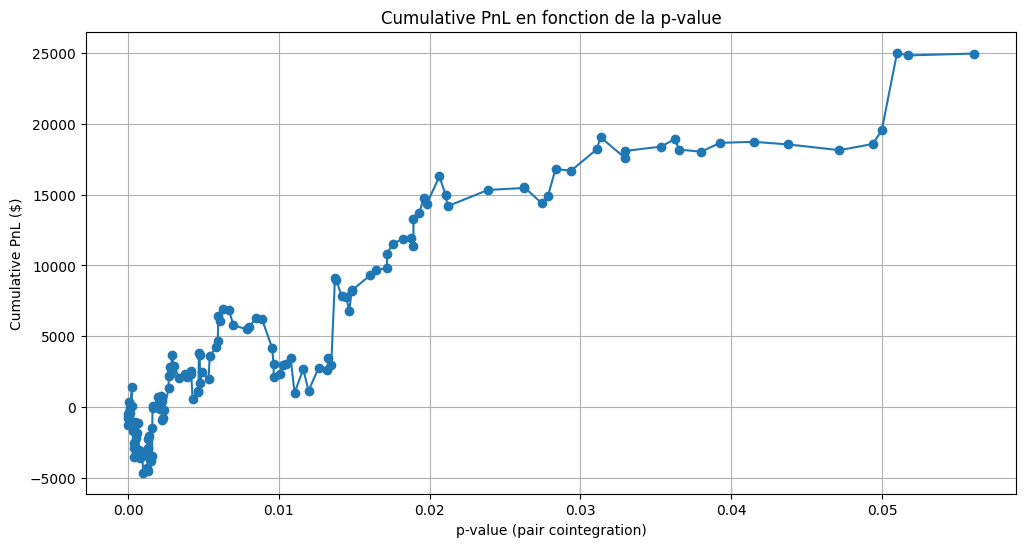

In [317]:

# Trier les paires par p-value croissante
df_sorted = all_metrics_df.sort_values(by='p_value')

# Calculer le PnL cumulatif
df_sorted['cumulative_pnl'] = df_sorted['total_pnl'].cumsum()

# Scatter / line plot
plt.figure(figsize=(12,6))
plt.plot(df_sorted['p_value'], df_sorted['cumulative_pnl'], marker='o', linestyle='-')
plt.xlabel('p-value (pair cointegration)')
plt.ylabel('Cumulative PnL ($)')
plt.title('Cumulative PnL en fonction de la p-value')
plt.grid(True)
plt.show()


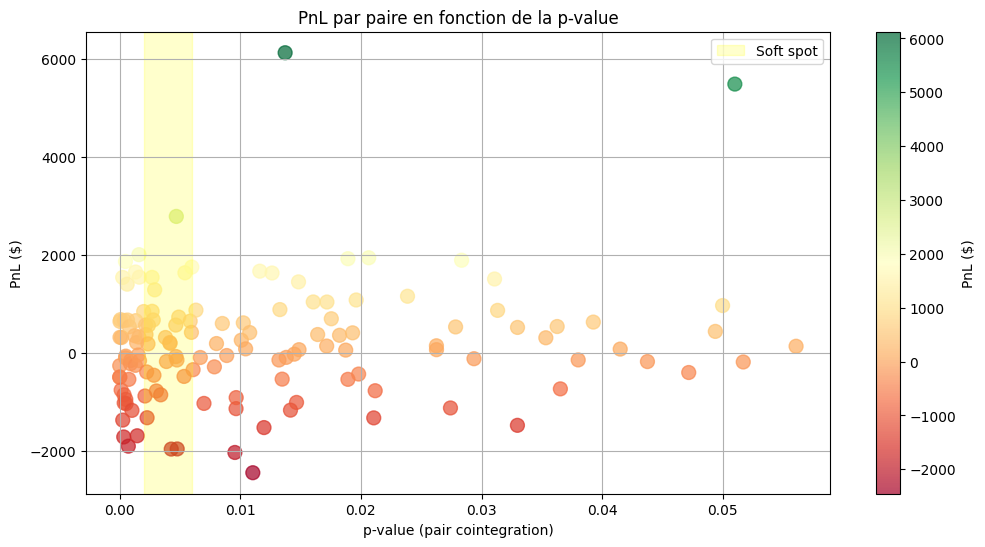

In [318]:
plt.figure(figsize=(12,6))
plt.scatter(df_sorted['p_value'], df_sorted['total_pnl'],
            c=df_sorted['total_pnl'], cmap='RdYlGn', s=100, alpha=0.7)
plt.colorbar(label='PnL ($)')
plt.xlabel('p-value (pair cointegration)')
plt.ylabel('PnL ($)')
plt.title('PnL par paire en fonction de la p-value')
plt.axvspan(0.002, 0.006, color='yellow', alpha=0.2, label='Soft spot')
plt.legend()
plt.grid(True)
plt.show()


In [320]:
# Définir les bins : de -inf à -2000, puis de -2000 à 6000 par pas de 500
# Bins sans doublons : (-inf, -2000], puis -2000 à 6000 par pas de 500
bins = [-np.inf, -2000] + list(range(-1500, 6001, 500))
labels = [f"{bins[i]} à {bins[i+1]}" for i in range(len(bins)-1)]

# Ajouter la colonne
all_metrics_df['PnL_bin'] = pd.cut(
    all_metrics_df['total_pnl'],
    bins=bins,
    labels=labels,
    right=False
)

# Compter
bin_counts = all_metrics_df['PnL_bin'].value_counts().sort_index()

print("Distribution des PnL par bin :")
for bin_label, count in bin_counts.items():
    print(f"{bin_label} : {count} paires")

Distribution des PnL par bin :
-inf à -2000 : 2 paires
-2000 à -1500 : 6 paires
-1500 à -1000 : 12 paires
-1000 à -500 : 13 paires
-500 à 0 : 28 paires
0 à 500 : 27 paires
500 à 1000 : 25 paires
1000 à 1500 : 7 paires
1500 à 2000 : 13 paires
2000 à 2500 : 1 paires
2500 à 3000 : 1 paires
3000 à 3500 : 0 paires
3500 à 4000 : 0 paires
4000 à 4500 : 0 paires
4500 à 5000 : 0 paires
5000 à 5500 : 1 paires
5500 à 6000 : 0 paires
